In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines import KaplanMeierFitter


In [193]:
raw_simulated_dataset = pd.read_csv('/mnt/data/simulated_listings1_wn.csv')
raw_simulated_dataset[['latitude', 'longitude']] = raw_simulated_dataset[['latitude', 'longitude']].astype(float)

In [194]:
raw_simulated_dataset.head()

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,time_on_market,sold,point,neighborhood
0,3.0,2.0,77,-23.624629,-46.738757,686126,2,75.838273,0,"23 37m 28.6658s S, 46 44m 19.5266s W",Paraisópolis
1,1.0,1.0,35,-23.553170,-46.648687,675152,3,215.490618,0,"23 33m 11.412s S, 46 38m 55.2732s W",Bixiga
2,3.0,2.0,97,-23.607094,-46.634414,871258,2,92.048200,0,"23 36m 25.5402s S, 46 38m 3.8922s W",Saúde
3,3.0,3.0,102,-23.539732,-46.567559,648740,3,32.000000,1,"23 32m 23.0363s S, 46 34m 3.21096s W",Tatuapé
4,2.0,1.0,78,-23.591993,-46.625481,968643,2,319.570866,0,"23 35m 31.1737s S, 46 37m 31.7305s W",Vila Mariana


In [8]:
def plot_lifelines(obs):
    """Plot a line for each observation.
    
    obs: DataFrame
    """
    for y, row in obs.iterrows():
        start = row['start']
        end = row['time_on_market']
        status = row['sold']
        value = row['value']
        if status == 0:
            # ongoing
            plt.hlines(value, start, end, color='C0')
        else:
            # complete
            plt.hlines(value, start, end, color='C1')
            plt.plot(end, value, marker='o', color='C1')
            
    plt.xlabel('Time (days)')
    plt.ylabel('Apt Value')
    plt.gca().invert_yaxis()

In [9]:
obs = raw_simulated_dataset[['value','time_on_market', 'sold']]
obs['start']=0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


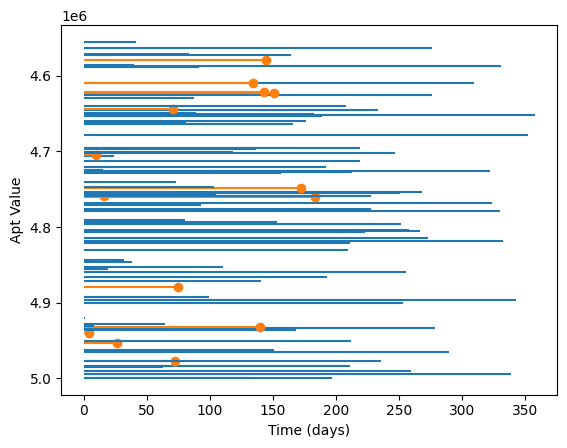

In [6]:
plot_lifelines(obs.nlargest(100, 'value'))

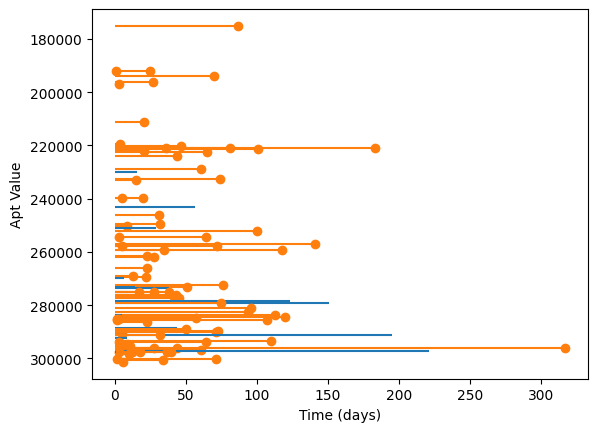

In [7]:
plot_lifelines(obs.nsmallest(100, 'value'))

# Logrank test

In [10]:
#Evento
E = (raw_simulated_dataset.sold)
# Tempo até evento
T = raw_simulated_dataset.time_on_market

group1 = (raw_simulated_dataset.interior_quality == 3)
label1 = "Interior Quality = 3"
group2 = (raw_simulated_dataset.interior_quality < 3)
label2 = "Interior Quality < 3"

In [11]:
def km_and_logrank(group1, group2, T, E, label1, label2):
    """
    group1: booleans identificando o grupo 1
    group2: booleans identificando o grupo 2
    T: pd.Series identificando o tempo da análise de sobrevivência
    E: pd.Series identificando o evento (censurado ou evento) da análise de sobrevivência
    label1: nome do grupo 1
    label2: nome do grupo 2
    """
    T1=T[group1]
    E1=E[group1]
    
    T2=T[group2]
    E2=E[group2]

    #logrank_test
    results=logrank_test(T1,T2,event_observed_A=E1, event_observed_B=E2)

    #Kaplan Meier plot
    kmf = KaplanMeierFitter()

    ax = plt.subplot(111)
    ax = kmf.fit(T1, E1, label=f"{label1}").plot(ax=ax, ci_show=True, show_censors=False)
    ax = kmf.fit(T2, E2, label=f"{label2}").plot(ax=ax, ci_show=True, show_censors=False)
    ax.set_xlabel('time_to_market')
    ax.set_ylabel('Survival function')
    plt.ylim([0, 1.1])
    anchored_text = AnchoredText("log-rank p-value: {:.3}".format(results.p_value), loc=3, frameon=False)
    ax.add_artist(anchored_text)

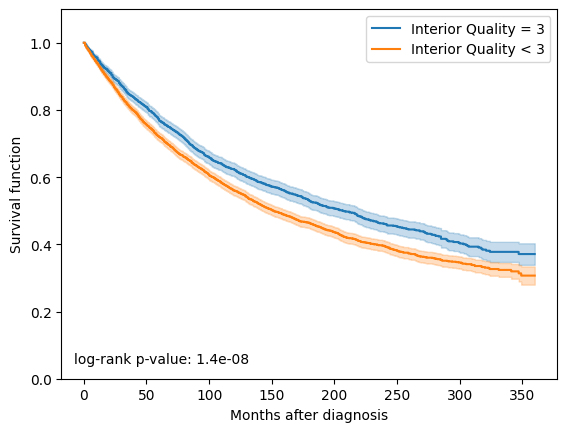

In [69]:
group1 = (raw_simulated_dataset.interior_quality == 3)
label1 = "Interior Quality = 3"
group2 = (raw_simulated_dataset.interior_quality < 3)
label2 = "Interior Quality < 3"

km_and_logrank(group1, group2, T, E, label1, label2)

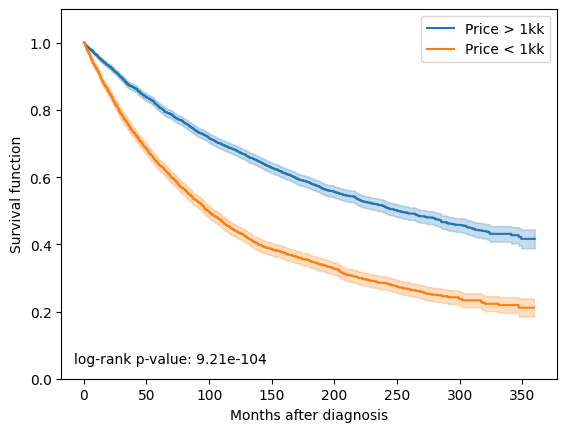

In [70]:
group1 = (raw_simulated_dataset.value > 1000000)
label1 = "Price > 1kk"
group2 = (raw_simulated_dataset.value < 1000000)
label2 = "Price < 1kk"

km_and_logrank(group1, group2, T, E, label1, label2)

# Multivariate logrank test

Aqui é avaliado como o preço influencia o evento de venda. Foram divididos em quantis os valores de venda do nosso dataset.

In [197]:
bins = raw_simulated_dataset['value'].quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 1])
raw_simulated_dataset_binned = raw_simulated_dataset.copy()
raw_simulated_dataset_binned['binned'] = pd.cut(raw_simulated_dataset['value'], bins)

results = multivariate_logrank_test(T, raw_simulated_dataset_binned['binned'], E, )
results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 6
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         771.45 <0.005    540.29

As curvas de sobrevivência são consideravelmente diferentes entre si podemos ver pelo p-value <0.005

# XGBOOST objective: survival cox

In [183]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl

In [195]:
dummies = pd.get_dummies(raw_simulated_dataset['neighborhood'])
raw_simulated_dataset = pd.concat([raw_simulated_dataset, dummies], axis=1).drop(columns='neighborhood')

In [201]:
raw_simulated_dataset.head()

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,time_on_market,sold,point,...,Vila Ida,Vila Ipojuca,Vila Leopoldina,Vila Mariana,Vila Olímpia,Vila Prudente,Vila Romana,Vila Sônia,Água Branca,Água Rasa
0,3.0,2.0,77,-23.624629,-46.738757,686126,2,75.838273,0,"23 37m 28.6658s S, 46 44m 19.5266s W",...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,35,-23.553170,-46.648687,675152,3,215.490618,0,"23 33m 11.412s S, 46 38m 55.2732s W",...,0,0,0,0,0,0,0,0,0,0
2,3.0,2.0,97,-23.607094,-46.634414,871258,2,92.048200,0,"23 36m 25.5402s S, 46 38m 3.8922s W",...,0,0,0,0,0,0,0,0,0,0
3,3.0,3.0,102,-23.539732,-46.567559,648740,3,32.000000,1,"23 32m 23.0363s S, 46 34m 3.21096s W",...,0,0,0,0,0,0,0,0,0,0
4,2.0,1.0,78,-23.591993,-46.625481,968643,2,319.570866,0,"23 35m 31.1737s S, 46 37m 31.7305s W",...,0,0,0,1,0,0,0,0,0,0


In [185]:
mask = (raw_simulated_dataset['sold']==0)
raw_simulated_dataset.loc[mask, 'time_on_market']  = raw_simulated_dataset.loc[mask, 'time_on_market']*-1

In [198]:
X = raw_simulated_dataset.drop(['sold','point', 'time_on_market'], axis=1)
y = raw_simulated_dataset['time_on_market']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

In [199]:
xgb_full = xgboost.DMatrix(X, label=y)

xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [188]:
# use validation set to choose # of trees
params = {
    "eta": 0.005,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, dtrain=xgb_train, num_boost_round =4000, evals = [(xgb_test, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:6.14004
[1000]	test-cox-nloglik:6.08844
[2000]	test-cox-nloglik:6.08684
[3000]	test-cox-nloglik:6.08841
[3999]	test-cox-nloglik:6.09079


In [200]:
# train final model on the full data set
params = {
    "eta": 0.005,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 4000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:8.03359
[1000]	test-cox-nloglik:7.96152
[2000]	test-cox-nloglik:7.94184
[3000]	test-cox-nloglik:7.92705
[3999]	test-cox-nloglik:7.91471


In [202]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(model.predict(xgb_test, ntree_limit=4000), y_test.tolist())


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


0.6624135753287663

In [205]:
import pickle
file_name = "/mnt/data/xgb_liquidity_survival_cox.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

# load
#xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [177]:
shap_values = shap.TreeExplainer(model).shap_values(X)

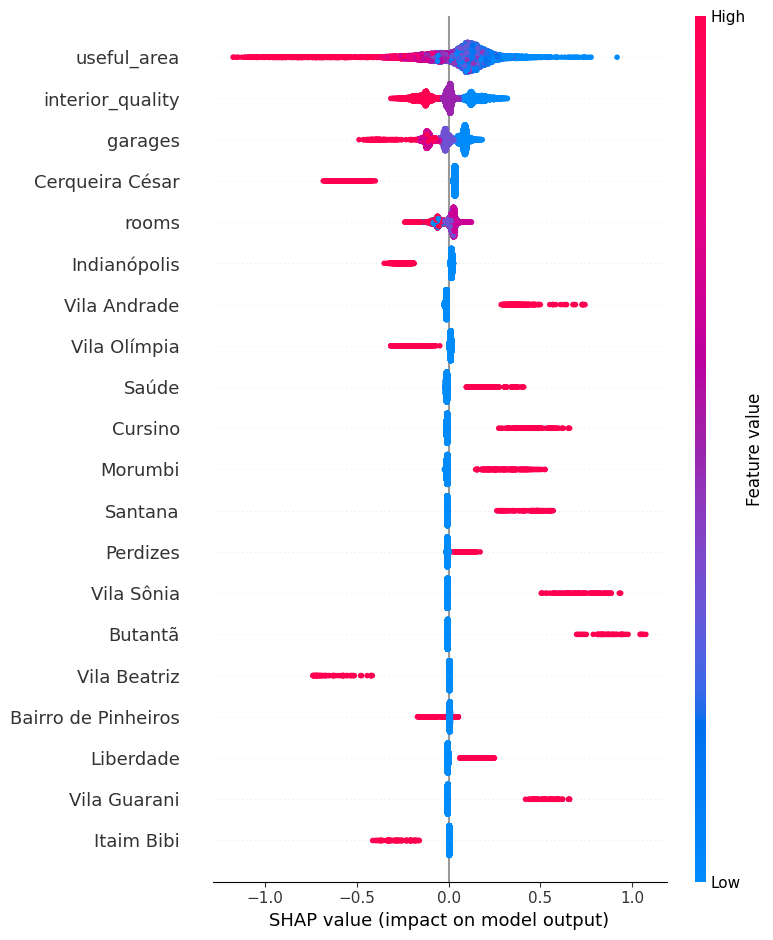

In [178]:
shap.summary_plot(shap_values, X)

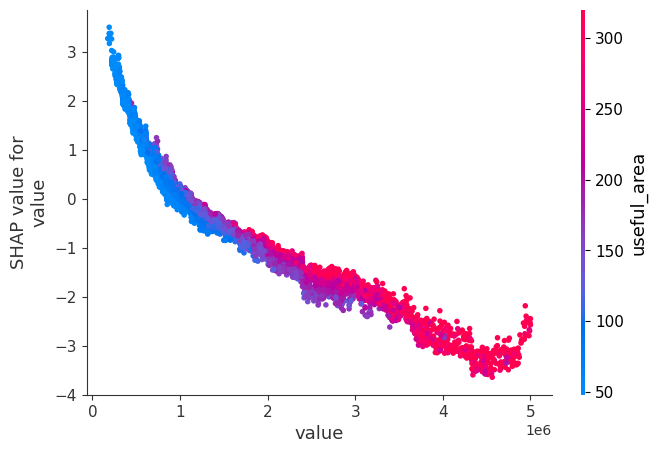

In [101]:
shap.dependence_plot("value", shap_values, X)

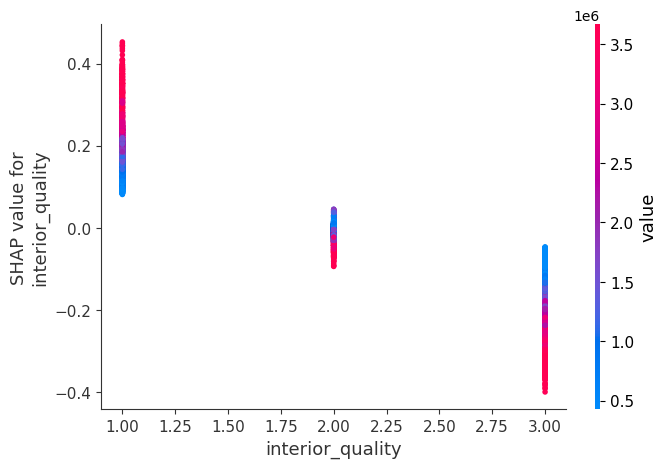

In [104]:
shap.dependence_plot("rank(2)", shap_values, X)

O interior quality aumenta o preço do apartamento e diminui a liquidez. interior quality parece intimamente ligada a preço, vamos olhar para um sem o outro 

# Isolando a variável interior_quality da variável value

In [154]:
interior_quality_df = raw_simulated_dataset[raw_simulated_dataset['interior_quality']<3]

X = interior_quality_df.drop(['sold','binned', 'latitude', 'longitude', 'point', 'time_on_market'], axis=1)
y = interior_quality_df['time_on_market']
xgb_test = xgboost.DMatrix(X, label=y)
preds = model.predict(xgb_test, ntree_limit=1500)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [156]:
interior_quality_df_3 = interior_quality_df.copy()
interior_quality_df_3['interior_quality'] = 3

X = interior_quality_df_3.drop(['sold','binned', 'latitude', 'longitude', 'point', 'time_on_market'], axis=1)
y = interior_quality_df_3['time_on_market']
xgb_test = xgboost.DMatrix(X, label=y)
preds_3 = model.predict(xgb_test, ntree_limit=1500)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [162]:
interior_quality_df['time_on_market_pred'] = preds
interior_quality_df['time_on_market_pred_3'] = preds_3
interior_quality_df['time_on_market_diff_pred'] = interior_quality_df['time_on_market_pred_3'] - interior_quality_df['time_on_market_pred']
interior_quality_df['time_on_market_diff'] = interior_quality_df['time_on_market_pred_3'] - interior_quality_df['time_on_market']
interior_quality_df[interior_quality_df['sold']==1][['time_on_market', 'time_on_market_diff','time_on_market_diff_pred']].head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,time_on_market,time_on_market_diff,time_on_market_diff_pred
6,20.0,-19.252582,-0.053262
21,77.0,-76.296357,-0.051321
23,121.0,-120.581780,-0.183621
32,86.0,-85.388840,-0.042835
34,40.0,-38.679754,-0.010849


In [164]:
 = interior_quality_df[interior_quality_df['sold']==1][['time_on_market', 'time_on_market_pred', 'time_on_market_diff','time_on_market_diff_pred']]
interior_quality_df[interior_quality_df['sold']==1][['time_on_market', 'time_on_market_pred', 'time_on_market_diff','time_on_market_diff_pred']].sort_values(by='time_on_market_diff', ascending=False)

,time_on_market,time_on_market_pred,time_on_market_diff,time_on_market_diff_pred
7317,3.0,6.173436,1.502890,-1.670546
7062,1.0,2.949629,1.325793,-0.623836
2341,2.0,4.467941,1.312894,-1.155046
7447,1.0,2.154067,1.096919,-0.057148
3728,1.0,1.611675,0.482136,-0.129539
...,...,...,...,...
4951,324.0,0.602665,-323.570922,-0.173588
1014,331.0,0.850136,-330.233174,-0.083310
3732,341.0,0.429309,-340.615111,-0.044419
1824,347.0,0.217072,-346.828615,-0.045687


<AxesSubplot:xlabel='time_on_market', ylabel='time_on_market_diff'>

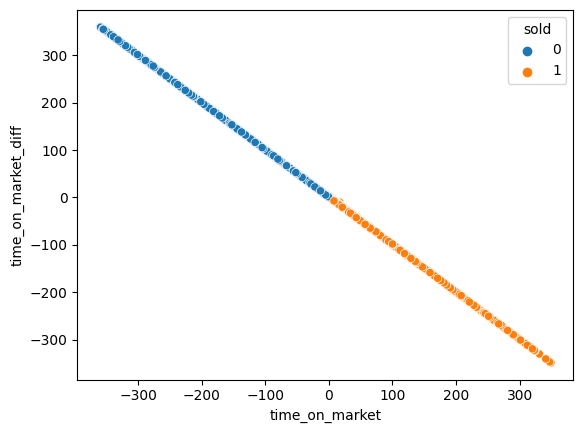

In [168]:
sns.scatterplot(data=interior_quality_df, x="time_on_market", y="time_on_market_diff", hue="sold")